In [1]:
import sys

sys.path.append("../")

In [34]:
import os.path

import matplotlib.pyplot as plt
from tqdm import tqdm

from monai.data import Dataset, DataLoader
from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    NormalizeIntensityd,
    Orientationd,
    CropForegroundd,
    HistogramNormalized
)
from custom_transforms import NormalizeAndClipIntensityd
import numpy as np

In [3]:
from glob import glob
supervised_dir = "/mnt/HDD2/flare2022/datasets/FLARE2022/Training/FLARE22_LabeledCase50"
def get_paths(path: str):
    paths = glob(os.path.join(supervised_dir, path, "*.nii.gz"))
    paths.sort()
    return paths

In [4]:
image_paths = get_paths("images")
label_paths = get_paths("labels")

data_dicts = tuple(
    {"image": img, "label": lab} for img, lab in zip(image_paths, label_paths)
)

In [5]:
VISUALIZATION_DIR = "../visualizations/"

In [82]:
keys = ("image", "label")
short_code = "nontrunc"
transforms = Compose(
    (
        LoadImaged(reader="NibabelReader", keys=keys),
        EnsureChannelFirstd(keys=keys),
        # NormalizeAndClipIntensityd(keys="image", clip_range=(-2.5, 2.5)),
        NormalizeIntensityd(keys="image"),
        # HistogramNormalized(keys="image", min=-1, max=1),
    )
)

In [83]:
num_workers = 4
dataset = Dataset(data_dicts, transforms)
dl = DataLoader(
    dataset,
    batch_size=1,
    num_workers=num_workers,
)

In [84]:
label_seperated_intensity = []
num_labels_with_bg = 14
for batch in tqdm(dl):
    image = batch["image"].flatten()
    label = batch["label"].flatten()

    for i in range(num_labels_with_bg):
        img = image[label == i]
        if len(label_seperated_intensity) == i:
            label_seperated_intensity.append(img)
        else:
            label_seperated_intensity[i] = np.concatenate((label_seperated_intensity[i], img))

100%|██████████| 50/50 [00:54<00:00,  1.09s/it]


In [85]:
import gc
gc.collect()

0

In [86]:
assert len(label_seperated_intensity) == num_labels_with_bg

In [87]:
np.unique(label)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13.], dtype=float32)

In [88]:
label_names = (
    "background",
    "liver",
    "right_kidney",
    "spleen",
    "pancreas",
    "aorta",
    "ivc",
    "rag",
    "lag",
    "gallbladder",
    "esophagus",
    "stomach",
    "duodenum",
    "left_kidney",
)

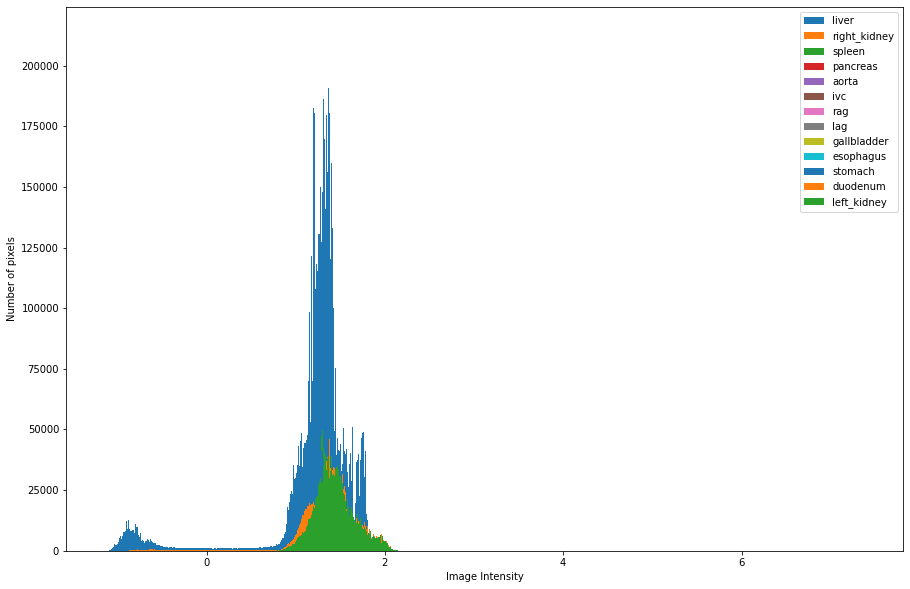

In [89]:
plt.figure(figsize=(15, 10))
start_index = 1
for lab, intensity in zip(label_names[start_index:], label_seperated_intensity[start_index:]):
    plt.hist(intensity, bins="auto", label=lab)
plt.legend()
plt.xlabel("Image Intensity")
plt.ylabel("Number of pixels")
plt.savefig(os.path.join(VISUALIZATION_DIR, f"label_combined_{short_code}.png"), bbox_inches="tight")

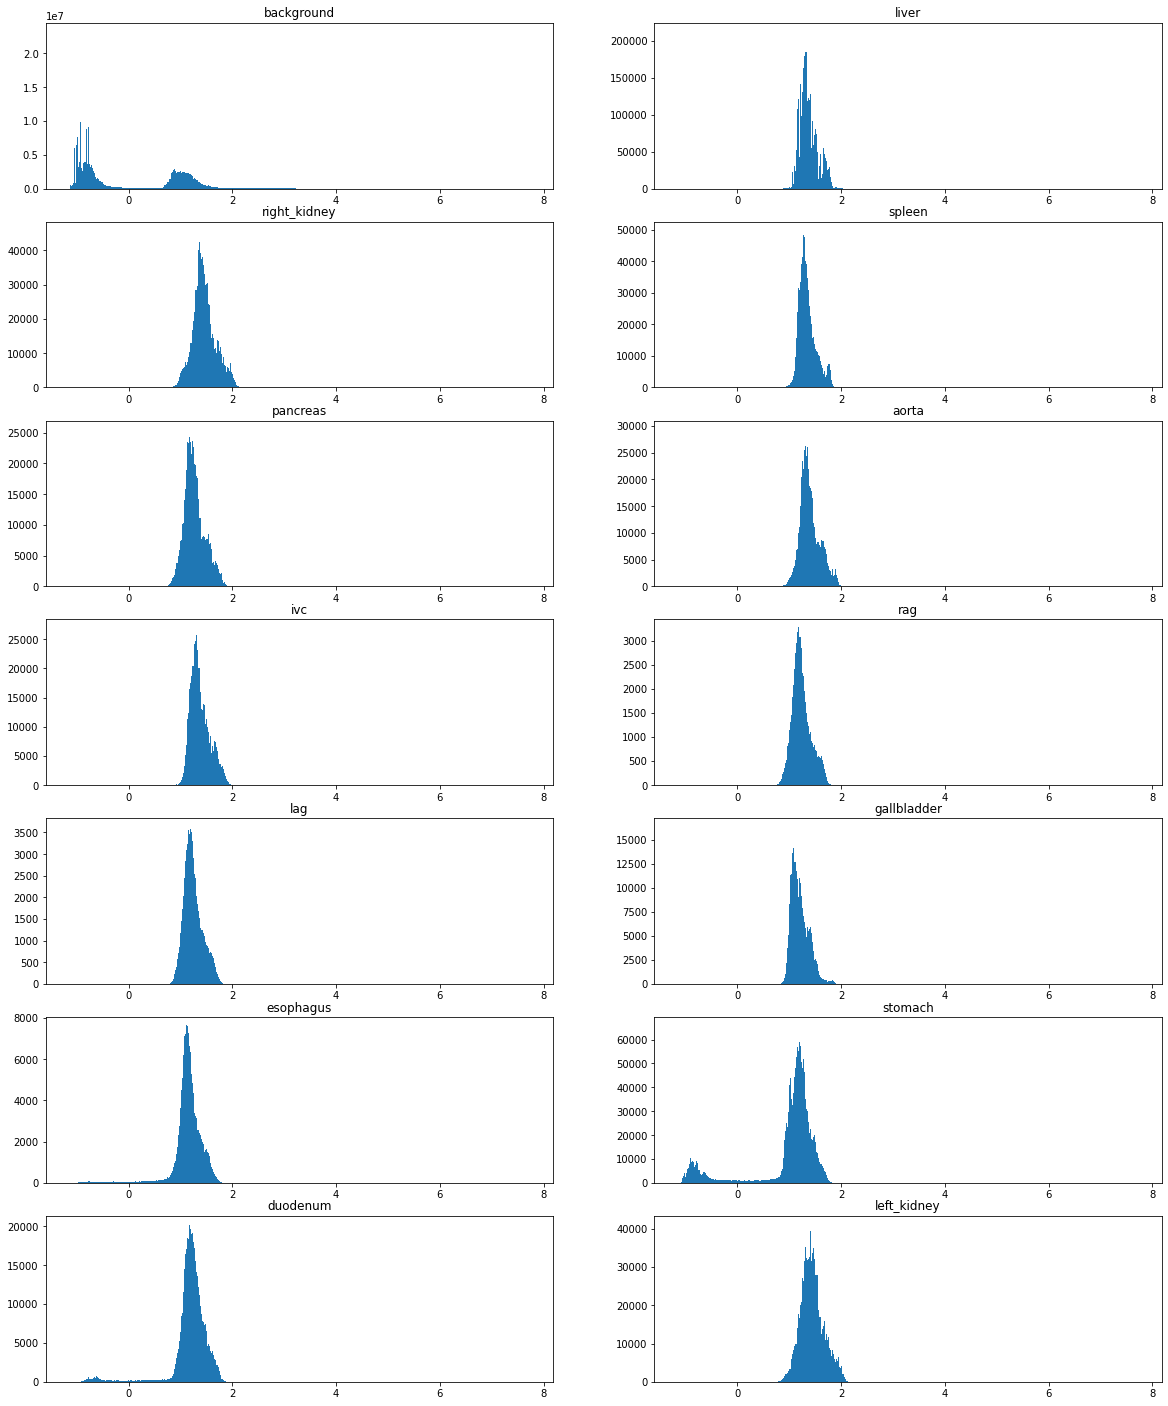

In [90]:
fig, axes = plt.subplots(7, 2, figsize=(20, 25), sharex=True)

for lab, intensity, ax in zip(label_names, label_seperated_intensity, axes.flat):
    ax.hist(intensity, bins="auto")
    ax.set_title(lab)
    ax.tick_params(labelbottom=True)
plt.savefig(os.path.join(VISUALIZATION_DIR, f"combined_{short_code}.png"), bbox_inches="tight")

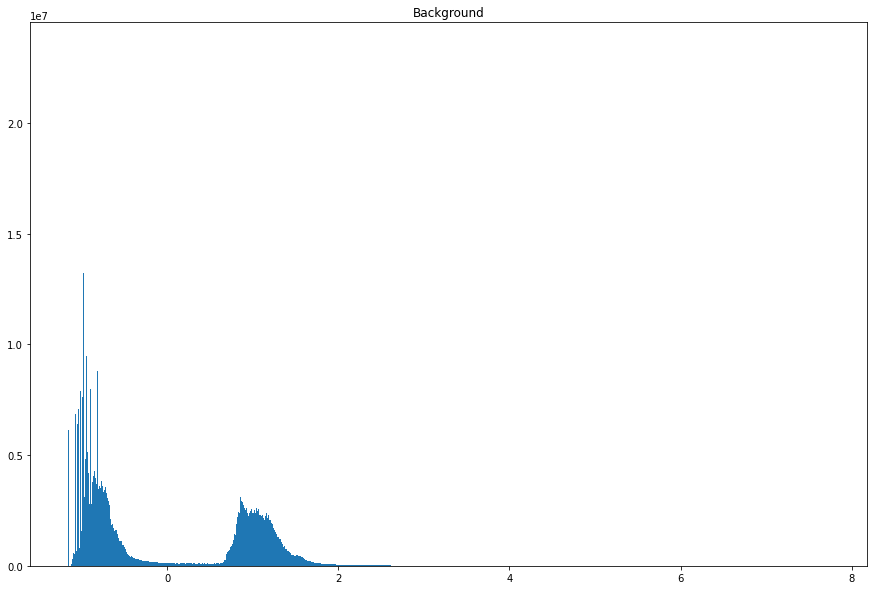

In [91]:
plt.figure(figsize=(15, 10))
plt.hist(label_seperated_intensity[0], bins="auto")
plt.title("Background");